In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import mu_0
from pathlib import Path

import em_utils.tdem_sounding as tdem_sounding
from simpeg.electromagnetics import time_domain as tdem
%matplotlib widget

## ProTEM

For the ProTEM data inversion, we are only going to concern ourselves with the **Z** data components, let's gather them all up, but keep them separate by repetition rate (for now)

In [2]:
file_name = Path('data')/'lab1_protem.txt'
with open(file_name, 'r') as f:
    lines = f.readlines()

The Z component H data are in lines 6 through 10 of the data file.

Let's grab the voltages.

> **IMPORTANT** Only consider record lines associated with valid gain and current combinations! For the H repetition rate, this was at 4 amps and a gain of 6. For the u repetition rate, this was at 1 Amp and a gain of 1.

In [3]:
Hz_volts = []
for line in lines[5:10]:
    voltages = line[27:27+20*7]
    voltages = np.array([voltages[7*i:7*(i+1)] for i in range(20)], dtype=float)
    Hz_volts.append(voltages)
Hz_volts = np.asarray(Hz_volts)

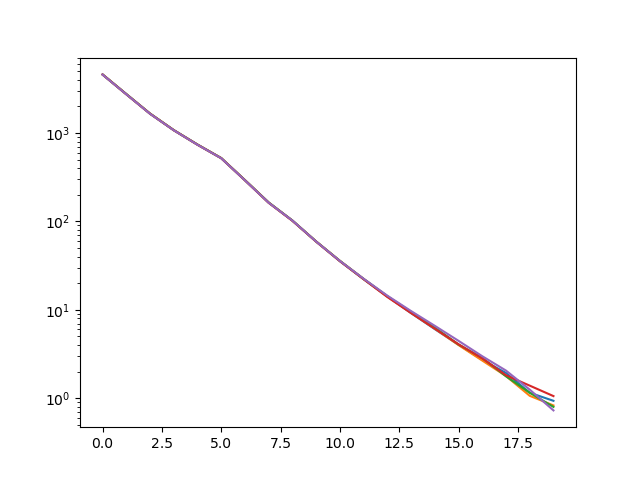

In [4]:
plt.semilogy(Hz_volts.T);

In [5]:
#TODO
# Do the same with the u repetition rate

uz_volts = []
for line in lines[33:38]:
    voltages = line[27:27+20*7]
    voltages = np.array([voltages[7*i:7*(i+1)] for i in range(20)], dtype=float)
    uz_volts.append(voltages)
uz_volts = np.asarray(uz_volts)

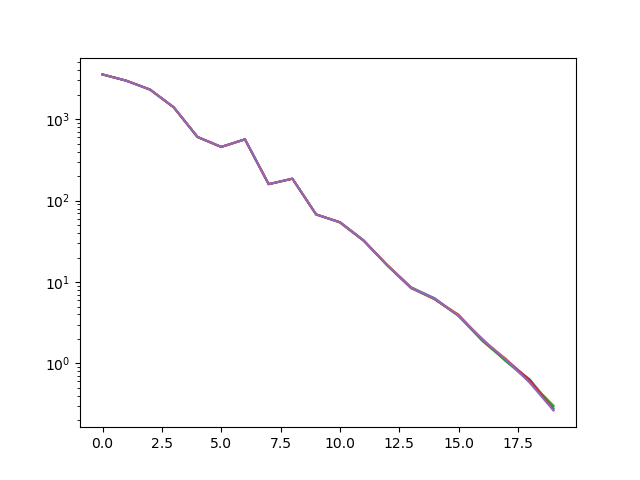

In [6]:
plt.figure()
plt.semilogy(uz_volts.T);

### get U and H data into nV/(m**2 * A)
* Assign times to each
* Normalize by currents and gains and rx_area

$$
v = \frac{v_{protem} 19200}{2^{n} I_{Tx} A_{Rx}}
$$
Where
* $v_{protem}$ is the voltage from the protem
* $n$ is the gain
* $I_{Tx}$ Is the transmitter current
* $A_{Rx}$ Is the receiver's effective area
* $V$ is then the normalized voltage in units of $nV/(m^2 A)$

> The 19200 is a calibration factor relevant for the ProTEM. 

In [7]:
def normalize_voltages(volts, current, gain, rx_area):
    # TODO: Fill this out
    return volts/(2**gain * current * rx_area) * 19.2 * 1000

In [8]:
rx_area = 31.4

h_gain = 6
h_current = 4
hz_normed = normalize_voltages(Hz_volts, h_current, h_gain, rx_area)

u_gain = 1
u_current = 1
uz_normed = normalize_voltages(uz_volts, u_current, u_gain, rx_area)

Text(0, 0.5, 'Normalized voltage: $nV/(m^2 A)$')

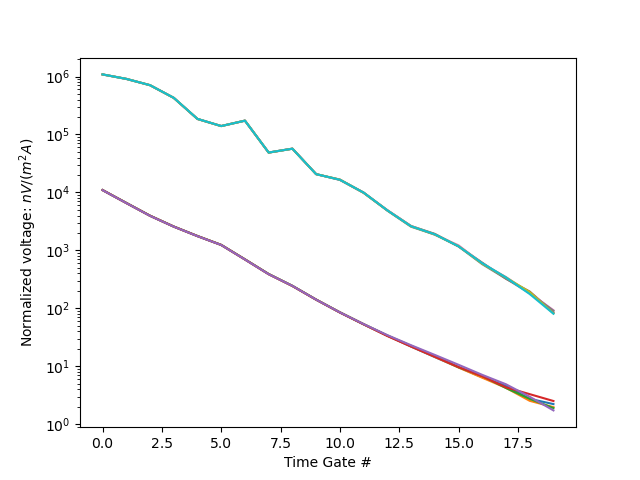

In [9]:
plt.figure()
plt.semilogy(hz_normed.T)
plt.semilogy(uz_normed.T)
plt.xlabel('Time Gate #')
plt.ylabel(r'Normalized voltage: $nV/(m^2 A)$')

Next we need to associate the correct times with each of the time gates.
These values can be found in the ProTEM's manual (for more repetiton rates as well), I've already copied them in for you for the H and u repetition rates

In [10]:
u_20_centers = np.array([6.813,8.688,11.13,14.19,18.07,23.06,29.44,
      37.56,47.94,61.13,77.94,99.38,126.7,166.4,206,262.8,
      335.2,427.7,545.6,695.9]) # in microseconds

In [11]:
H_20_centers = np.array([88.125,106.875,131.25,161.875,200.625,250.625,
      314.375,395.625,499.375,631.25,799.375,1013.75,1286.875,
      1635.625,2080.625,2648.125,3372.5,4296.875,5475.5,6978.5]) # in microseconds

> If you've normalized the voltages correctly up till here, the H repetition should follow on from the u repetiton rate.

Text(0, 0.5, 'Normalized voltage: $nV/(m^2 A)$')

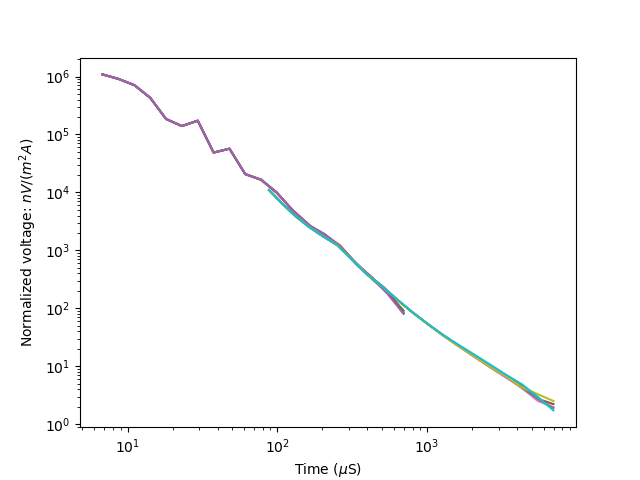

In [12]:
plt.figure()
plt.loglog(u_20_centers, uz_normed.T)
plt.loglog(H_20_centers, hz_normed.T);
plt.xlabel(r'Time ($\mu$S)')
plt.ylabel(r'Normalized voltage: $nV/(m^2 A)$')

Let's now average the 5 records of the data for each repetition together

In [13]:
u_means = uz_normed.mean(axis=0)
u_std = uz_normed.std(axis=0)
h_means = hz_normed.mean(axis=0)
h_std = hz_normed.std(axis=0)

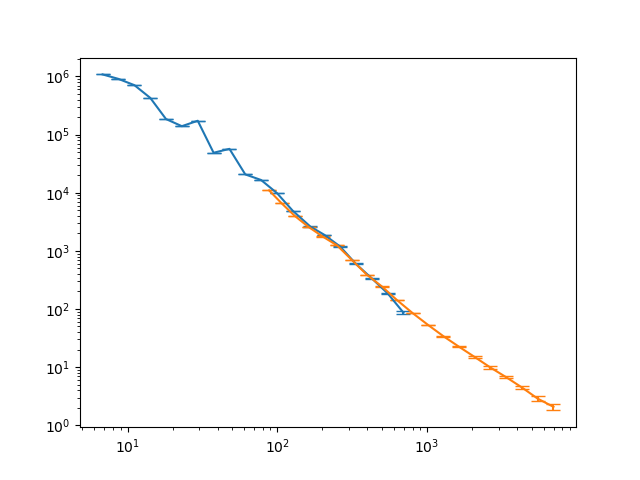

In [14]:
plt.figure()
plt.errorbar(u_20_centers, u_means, u_std, capsize=5)
plt.errorbar(H_20_centers, h_means, h_std, capsize=5)
plt.xscale('log')
plt.yscale('log')

> **Question** How does the error change for the early gates and the late gates? How does the error compare betweenn the H and u repetition rates?

### $\sigma_{app}$
Plot the late-time apparent conductivities for the averaged ProTEM data set! This can be useful for a starting point for inversions.

In [15]:
def app_cond_late_time(v, t, tx_area):
    """
    Parameters
    ----------
    v : normalized voltage in units of V/(m^2 A)
    t : time in seconds.
    tx_area : The transmitter area (m^2)s

    Notes
    -----
    Be careful about units here!
    """
    temp = v**2 * t**5 / (tx_area**2 * mu_0**5) * 20**2
    return temp**(1/3) * np.pi

Text(0.5, 0, 'time ($\\mu$s)')

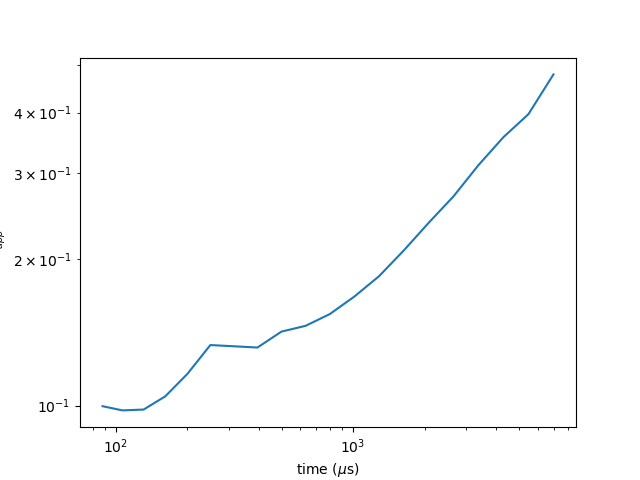

In [16]:
t = u_20_centers
sigma_a = app_cond_late_time(u_means*1E-9, t*1E-6, 40 * 40)
plt.loglog(t, sigma_a)

t = H_20_centers
sigma_a = app_cond_late_time(h_means*1E-9, t*1E-6, 40 * 40)
plt.figure()
plt.loglog(t, sigma_a)
plt.ylabel(r'$\sigma_{app}$')
plt.xlabel(r'time ($\mu$s)')

Now let's invert this data set!

In [55]:
### This sets up a simpeg survey for the ProTEM with the setup we used

# This is the shape of the 40 x 40 meter wire we used (Centered at 0)
tx_shape = np.array([
    [-20.0, -20.0, 0],
    [20.0, -20.0, 0],
    [20.0, 20.0, 0],
    [-20.0, 20.0, 0],
    [-20.0, -20.0, 0],
])

#protem_waveform = tdem.sources.RampOffWaveform(2.5E-6)
protem_waveform = tdem.sources.PiecewiseLinearWaveform([-2.5E-6, 0],[1, 0])

rx_u = tdem.receivers.PointMagneticFluxTimeDerivative(
    locations=[0, 0, 0], times=u_20_centers*1E-6, orientation='Z'
)
rx_h = tdem.receivers.PointMagneticFluxTimeDerivative(
    locations=[0, 0, 0], times=H_20_centers*1E-6, orientation='Z'
)

src = tdem.sources.LineCurrent(
    [rx_u, rx_h],
    location=tx_shape,
    waveform=protem_waveform,
    moment=40*40
)
src.moment = 40 * 40

protem_survey = tdem.Survey(src)

In [56]:
out = tdem_sounding.TDEMSoundingInteract(
    protem_survey,
    observed_voltage=np.r_[u_means, h_means]*1E-9)
out.display()

In [53]:
import importlib
importlib.reload(tdem_sounding)

<module 'em_utils.tdem_sounding' from 'E:\\Repos\\gpgn-319\\labs\\EM\\em_utils\\tdem_sounding.py'>

In [54]:
out._dpred()

array([2.94002034e-04, 2.94000949e-04, 2.93970856e-04, 2.93633787e-04,
       2.91680950e-04, 2.84853590e-04, 2.68964137e-04, 2.41859298e-04,
       2.05045553e-04, 1.63549016e-04, 1.22900283e-04, 8.74185473e-05,
       5.92601638e-05, 3.64793874e-05, 2.42046303e-05, 1.47607374e-05,
       8.79759358e-06, 5.14177873e-06, 2.96169095e-06, 1.68616016e-06,
       1.04133271e-04, 7.81843077e-05, 5.58047556e-05, 3.83943725e-05,
       2.54984785e-05, 1.62858027e-05, 1.01034540e-05, 6.11662634e-06,
       3.62510815e-06, 2.11584433e-06, 1.21790415e-06, 6.93147791e-07,
       3.91082158e-07, 2.18876097e-07, 1.21755188e-07, 6.74226288e-08,
       3.71840562e-08, 2.04442516e-08, 1.12181390e-08, 6.14557007e-09])